# Image classification

In [1]:
import time
from collections import OrderedDict

import numpy as np
import torch
import torchvision
from IPython.display import display
from matplotlib import pyplot as plt
from pandas import DataFrame
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
from sklearn.neighbors import NearestCentroid

In [2]:
labels = [
    'top', 'trousers', 'pullover', 'dress', 'coat',
    'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']

In [3]:
data = torchvision.datasets.FashionMNIST(
    root='../data/fashion-mnist', train=True, download=True)
train_x = np.array(data.data)
train_y = np.array(data.targets)

data = torchvision.datasets.FashionMNIST(
    root='../data/fashion-mnist', train=False, download=True)
val_x = np.array(data.data[:5000])
val_y = np.array(data.targets[:5000])
test_x = np.array(data.data[5000:10000])
test_y = np.array(data.targets[5000:10000])

In [4]:
data = OrderedDict()
for name, y in (('training', train_y), ('validation', val_y), ('test', test_y)):
    _, counts = np.unique(y, return_counts=True)
    data[f'{name} set'] = OrderedDict([(labels[i], c) for i, c in enumerate(counts)])
    data[f'{name} set']['total'] = y.shape[0]
display(DataFrame(data).T)

,top,trousers,pullover,dress,coat,sandal,shirt,sneaker,bag,ankle boot,total
training set,6000,6000,6000,6000,6000,6000,6000,6000,6000,6000,60000
validation set,507,481,521,500,521,485,482,500,526,477,5000
test set,493,519,479,500,479,515,518,500,474,523,5000


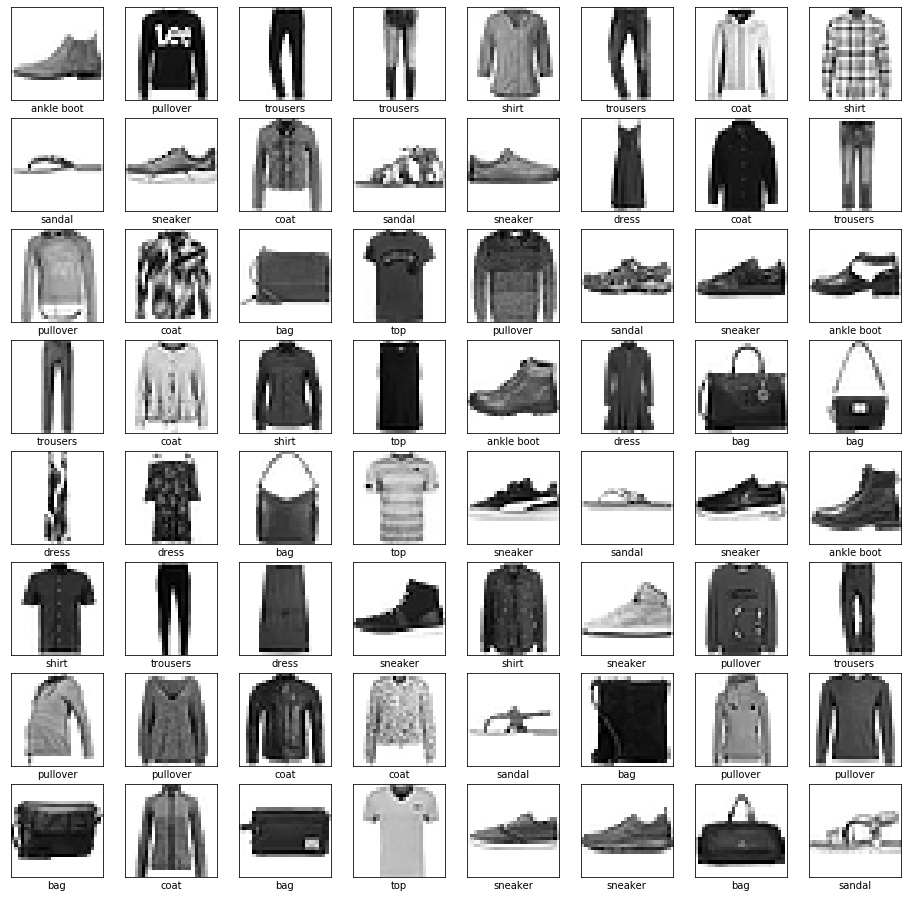

In [5]:
plt.figure(figsize=(16, 16))
for i in range(64):
    plt.subplot(8, 8, i + 1)
    plt.imshow(val_x[i], cmap=plt.cm.binary)
    plt.xlabel(labels[val_y[i]])
    plt.xticks([])
    plt.yticks([])
plt.show()

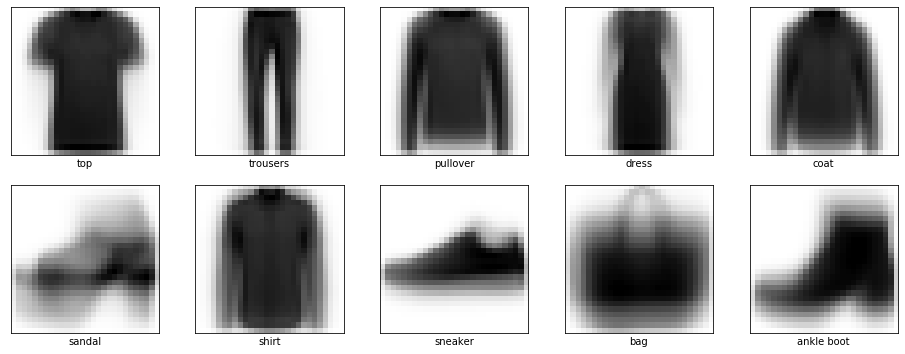

In [6]:
centroids = [(l, train_x[train_y == i].mean(axis=0)) for i, l in enumerate(labels)]
plt.figure(figsize=(16, 6))
for i, (label, image) in enumerate(centroids):
    plt.subplot(2, 5, i + 1)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(label)
    plt.xticks([])
    plt.yticks([])
plt.show()

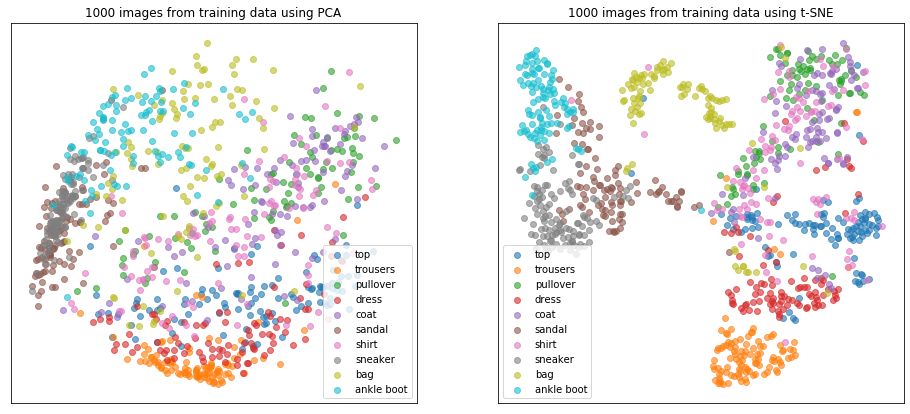

In [7]:
plt.figure(figsize=(16, 7))
for i, (name, alg) in enumerate([
        ('PCA', PCA(n_components=2)), ('t-SNE', TSNE(n_components=2))]):
    x_reduced = alg.fit_transform(train_x[:1000].reshape(-1, 784))
    y_reduced = train_y[:1000]
    data = [(l, x_reduced[y_reduced == i]) for i, l in enumerate(labels)]
    plt.subplot(1, 2, i + 1)
    for label, points in data:
        plt.scatter(points[:, 0], points[:, 1], alpha=0.6, label=label)
    plt.title(f'1000 images from training data using {name}')
    plt.legend()
    plt.xticks([])
    plt.yticks([])
plt.show()

In [8]:
def plot_history(history):
    plt.figure(figsize=(16, 5))
    for i, (name, key) in enumerate([('accuracy', 'acc'), ('loss', 'loss')]):
        plt.subplot(1, 2, i + 1)
        plt.plot(history['epoch'], history[key], label=f'training {name}')
        plt.plot(history['epoch'], history[f'val_{key}'], label=f'validation {name}')
        plt.title(f'{name} during training')
        plt.legend()
        plt.xlabel('epoch')
        plt.ylabel(name)
    plt.show()

def plot_predictions(model, x=val_x[:64], y=val_y[:64], labels=labels):
    y_pred = model.predict(x)
    n = np.ceil(np.sqrt(x.shape[0]))
    plt.figure(figsize=(16, 18))
    for i in range(x.shape[0]):
        plt.subplot(n, n, i + 1)
        plt.imshow(x[i], cmap=plt.cm.binary)
        plt.xlabel(
            f'pred: {labels[y_pred[i]]}\ntrue: {labels[y[i]]}',
            color='green' if y_pred[i] == y[i] else 'red')
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [9]:
models = OrderedDict()

In [10]:
class SKLearnClassifier:

    def __init__(self, model):
        self.model = model

    def fit(self, train_x, train_y):
        start = time.time()
        self.model.fit(train_x.reshape(train_x.shape[0], -1), train_y)
        print(f'Finished training in {time.time() - start:.2f}s')

    def predict(self, x):
        return self.model.predict(x.reshape(x.shape[0], -1))

In [11]:
models['nearest centroid'] = SKLearnClassifier(NearestCentroid(metric='euclidean'))

In [12]:
models['nearest centroid'].fit(train_x, train_y)

Finished training in 0.05s


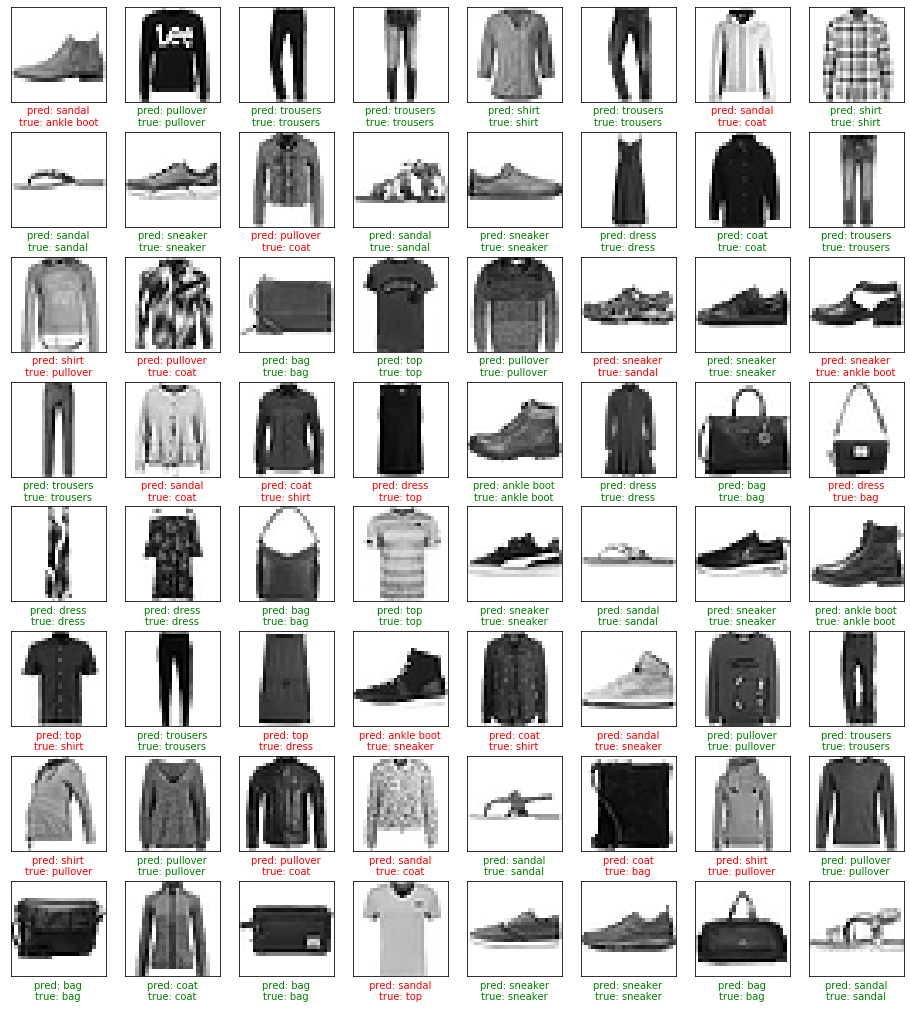

In [13]:
plot_predictions(models['nearest centroid'])

In [14]:
models['random forest'] = SKLearnClassifier(
    RandomForestClassifier(n_estimators=50, max_depth=25, n_jobs=-1))

In [15]:
models['random forest'].fit(train_x, train_y)

Finished training in 6.64s


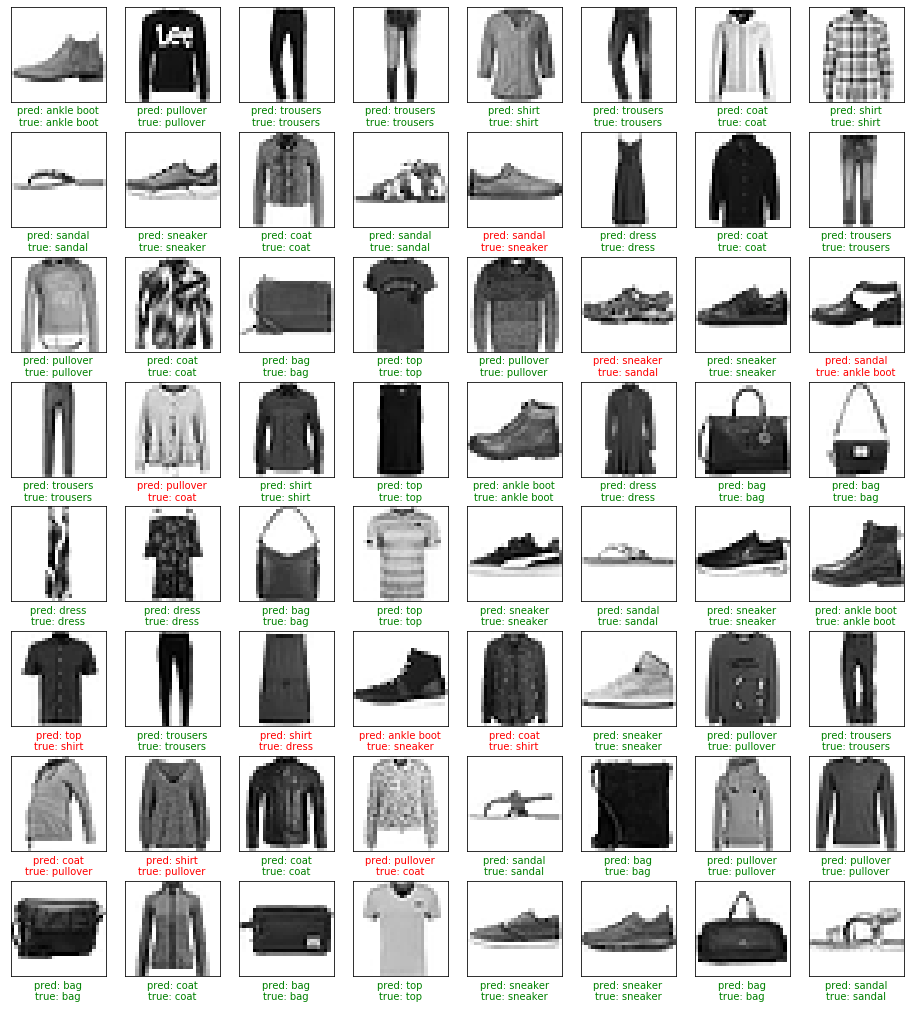

In [16]:
plot_predictions(models['random forest'])

In [17]:
class PyTorchClassifier(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def fit(self, train_x, train_y, val_x, val_y, epochs, batch_size=250, shuffle=True):
        self.to(self.device)
        train_loader = self._build_loader_xy(
            train_x, train_y, batch_size=batch_size, shuffle=shuffle)
        val_loader = self._build_loader_xy(val_x, val_y, batch_size=1000, shuffle=False)
        history = {'epoch': [], 'loss': [], 'acc': [], 'val_loss': [], 'val_acc': []}
        for epoch in range(1, epochs+1):
            self.train()
            start_time = time.time()
            loss, acc = 0, 0
            for x, y in train_loader:
                # Batch training step
                self.optimizer.zero_grad()
                x, y = x.to(self.device), y.to(self.device)
                y_pred = self(x)
                loss_ = self.loss(y_pred, y)
                loss_.backward()
                self.optimizer.step()
                # Calculate metrics for batch
                loss += float(loss_) * len(x)
                acc += int((y_pred.argmax(dim=1) == y).sum())
            # Calculate metrics for epoch
            loss /= len(train_loader.dataset)
            acc /= len(train_loader.dataset)
            val_loss, val_acc = self._evaluate(val_loader)
            duration = time.time() - start_time
            # Save training history
            history['epoch'].append(epoch)
            history['loss'].append(loss)
            history['acc'].append(acc)
            history['val_loss'].append(val_loss)
            history['val_acc'].append(val_acc)
            print(
                f'[{epoch:{len(str(epochs))}}/{epochs}] {duration:.1f}s'
                f' - loss: {loss:.4f} - acc: {acc:.4f}'
                f' - val_loss: {val_loss:.4f} - val_acc: {val_acc:.4f}')
        return history

    def predict(self, x, batch_size=1000):
        self.to(self.device)
        data_loader = self._build_loader_x(x, batch_size=batch_size, shuffle=False)
        self.eval()
        preds = []
        for x, in data_loader:
            x = x.to(self.device)
            preds.extend(self(x).argmax(dim=1).cpu())
        return np.array(preds)

    def _evaluate(self, data_loader):
        self.to(self.device)
        self.eval()
        loss, acc = 0, 0
        for x, y in data_loader:
            x, y = x.to(self.device), y.to(self.device)
            y_pred = self(x)
            loss += float(self.loss(y_pred, y)) * len(x)
            acc += int((y_pred.argmax(dim=1) == y).sum())
        loss /= len(data_loader.dataset)
        acc /= len(data_loader.dataset)
        return loss, acc

    @staticmethod
    def _build_loader_x(x, batch_size, shuffle):
        return torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(torch.FloatTensor(x) / 255),
            batch_size=batch_size, shuffle=shuffle)

    @staticmethod
    def _build_loader_xy(x, y, batch_size, shuffle):
        return torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(torch.FloatTensor(x) / 255, torch.LongTensor(y)),
            batch_size=batch_size, shuffle=shuffle)

In [18]:
class MultilayerPerceptron(PyTorchClassifier):

    def __init__(self):
        super().__init__()
        self.layers = torch.nn.ModuleList([
            torch.nn.Dropout(0.25),
            torch.nn.Linear(784, 150),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.25),
            torch.nn.Linear(150, 10),
        ])
        
        self.loss = torch.nn.functional.cross_entropy
        self.optimizer = torch.optim.Adam(self.parameters())

    def forward(self, x):
        x = x.view(x.size()[0], -1)
        for layer in self.layers:
            x = layer(x)
        return x

In [19]:
models['multilayer perceptron'] = MultilayerPerceptron()

In [20]:
history = models['multilayer perceptron'].fit(train_x, train_y, val_x, val_y, epochs=50)

[ 1/50] 0.8s - loss: 0.7279 - acc: 0.7480 - val_loss: 0.5091 - val_acc: 0.8274
[ 2/50] 0.7s - loss: 0.5083 - acc: 0.8202 - val_loss: 0.4459 - val_acc: 0.8464
[ 3/50] 0.7s - loss: 0.4626 - acc: 0.8343 - val_loss: 0.4303 - val_acc: 0.8464
[ 4/50] 0.7s - loss: 0.4335 - acc: 0.8445 - val_loss: 0.3996 - val_acc: 0.8568
[ 5/50] 0.7s - loss: 0.4123 - acc: 0.8501 - val_loss: 0.3864 - val_acc: 0.8602
[ 6/50] 0.7s - loss: 0.4010 - acc: 0.8542 - val_loss: 0.3817 - val_acc: 0.8634
[ 7/50] 0.7s - loss: 0.3901 - acc: 0.8578 - val_loss: 0.3683 - val_acc: 0.8696
[ 8/50] 0.7s - loss: 0.3807 - acc: 0.8619 - val_loss: 0.3686 - val_acc: 0.8662
[ 9/50] 0.7s - loss: 0.3729 - acc: 0.8624 - val_loss: 0.3624 - val_acc: 0.8650
[10/50] 0.8s - loss: 0.3672 - acc: 0.8669 - val_loss: 0.3552 - val_acc: 0.8706
[11/50] 0.8s - loss: 0.3582 - acc: 0.8695 - val_loss: 0.3488 - val_acc: 0.8746
[12/50] 0.7s - loss: 0.3529 - acc: 0.8698 - val_loss: 0.3434 - val_acc: 0.8708
[13/50] 0.7s - loss: 0.3478 - acc: 0.8716 - val_loss

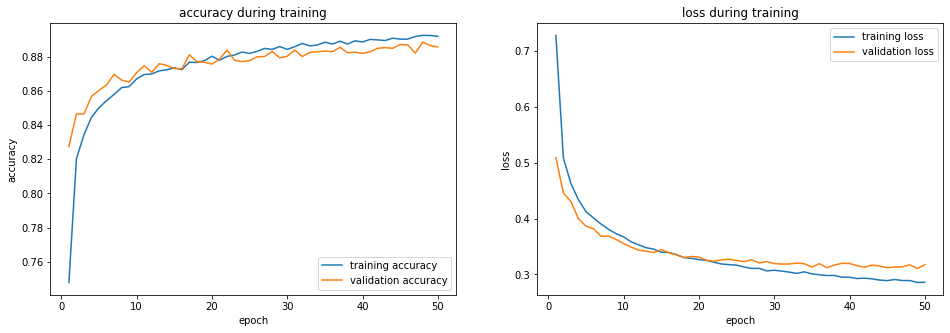

In [21]:
plot_history(history)

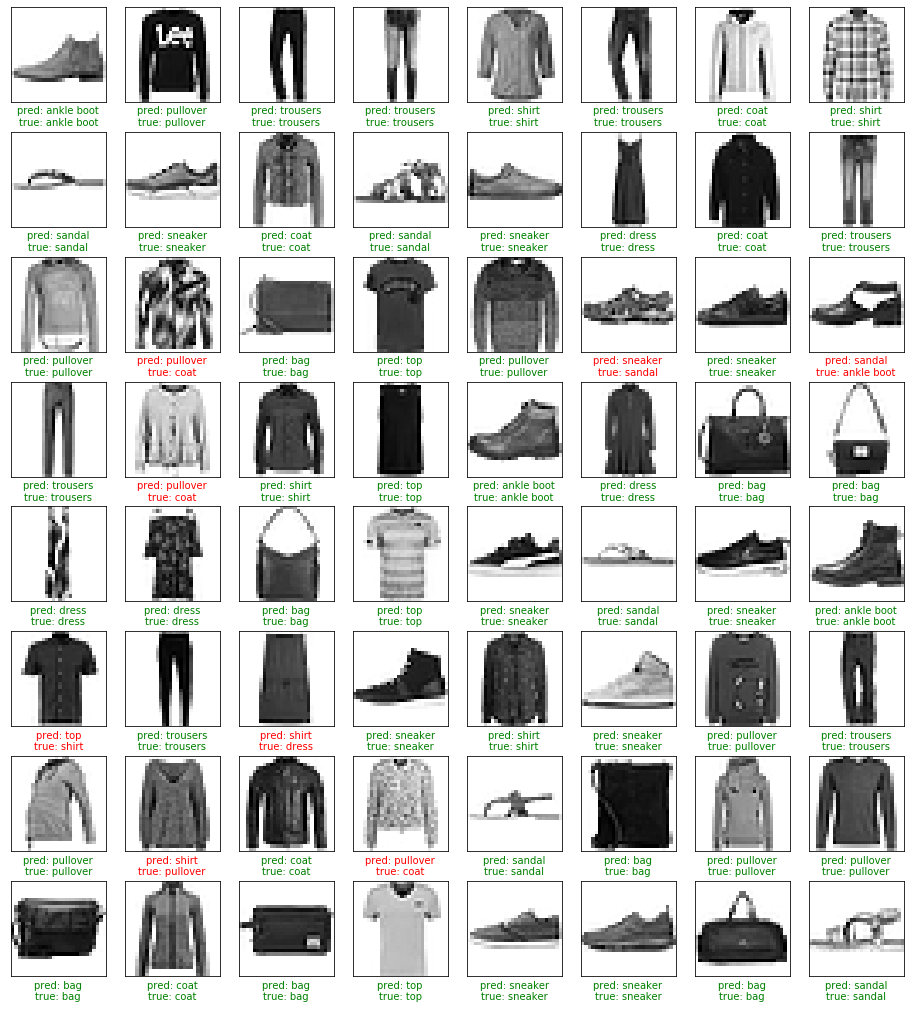

In [22]:
plot_predictions(models['multilayer perceptron'])

In [23]:
class ConvolutionalNet(PyTorchClassifier):

    def __init__(self):
        super().__init__()
        self.layers1 = torch.nn.ModuleList([
            torch.nn.Conv2d(1, 32, 5),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Dropout2d(0.25),
            torch.nn.Conv2d(32, 64, 5),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Dropout2d(0.25),
            torch.nn.Conv2d(64, 128, 1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
        ])
        self.layers2 = torch.nn.ModuleList([
            torch.nn.Dropout(0.25),
            torch.nn.Linear(512, 150),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.25),
            torch.nn.Linear(150, 10),
        ])

        self.loss = torch.nn.functional.cross_entropy
        self.optimizer = torch.optim.Adam(self.parameters())

    def forward(self, x):
        x = x.view(x.size()[0], 1, *x.size()[1:])
        for layer in self.layers1:
            x = layer(x)
        x = x.view(x.size()[0], -1)
        for layer in self.layers2:
            x = layer(x)
        return x

In [24]:
models['convolutional net'] = ConvolutionalNet()

In [25]:
history = models['convolutional net'].fit(train_x, train_y, val_x, val_y, epochs=50)

[ 1/50] 3.7s - loss: 0.9297 - acc: 0.6554 - val_loss: 0.5857 - val_acc: 0.7824
[ 2/50] 3.1s - loss: 0.5896 - acc: 0.7829 - val_loss: 0.4986 - val_acc: 0.8176
[ 3/50] 3.3s - loss: 0.5063 - acc: 0.8167 - val_loss: 0.4199 - val_acc: 0.8458
[ 4/50] 3.1s - loss: 0.4626 - acc: 0.8303 - val_loss: 0.3982 - val_acc: 0.8552
[ 5/50] 3.1s - loss: 0.4337 - acc: 0.8418 - val_loss: 0.3728 - val_acc: 0.8608
[ 6/50] 3.1s - loss: 0.4110 - acc: 0.8488 - val_loss: 0.3554 - val_acc: 0.8708
[ 7/50] 3.3s - loss: 0.3959 - acc: 0.8557 - val_loss: 0.3474 - val_acc: 0.8764
[ 8/50] 3.2s - loss: 0.3796 - acc: 0.8607 - val_loss: 0.3385 - val_acc: 0.8770
[ 9/50] 3.2s - loss: 0.3691 - acc: 0.8649 - val_loss: 0.3336 - val_acc: 0.8766
[10/50] 3.2s - loss: 0.3555 - acc: 0.8696 - val_loss: 0.3255 - val_acc: 0.8816
[11/50] 3.1s - loss: 0.3511 - acc: 0.8704 - val_loss: 0.3116 - val_acc: 0.8860
[12/50] 3.1s - loss: 0.3404 - acc: 0.8741 - val_loss: 0.3102 - val_acc: 0.8860
[13/50] 3.1s - loss: 0.3341 - acc: 0.8763 - val_loss

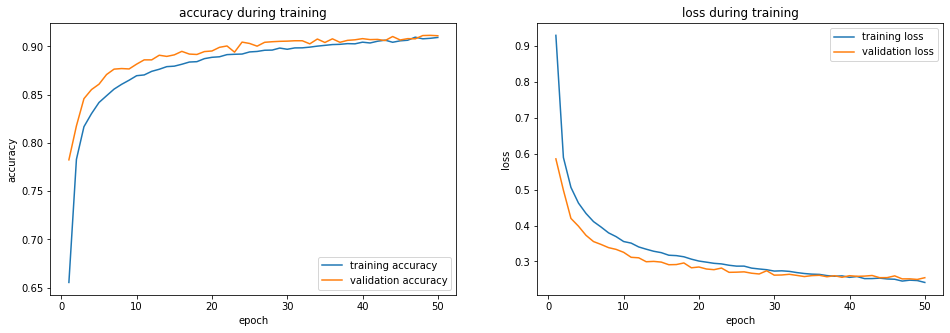

In [26]:
plot_history(history)

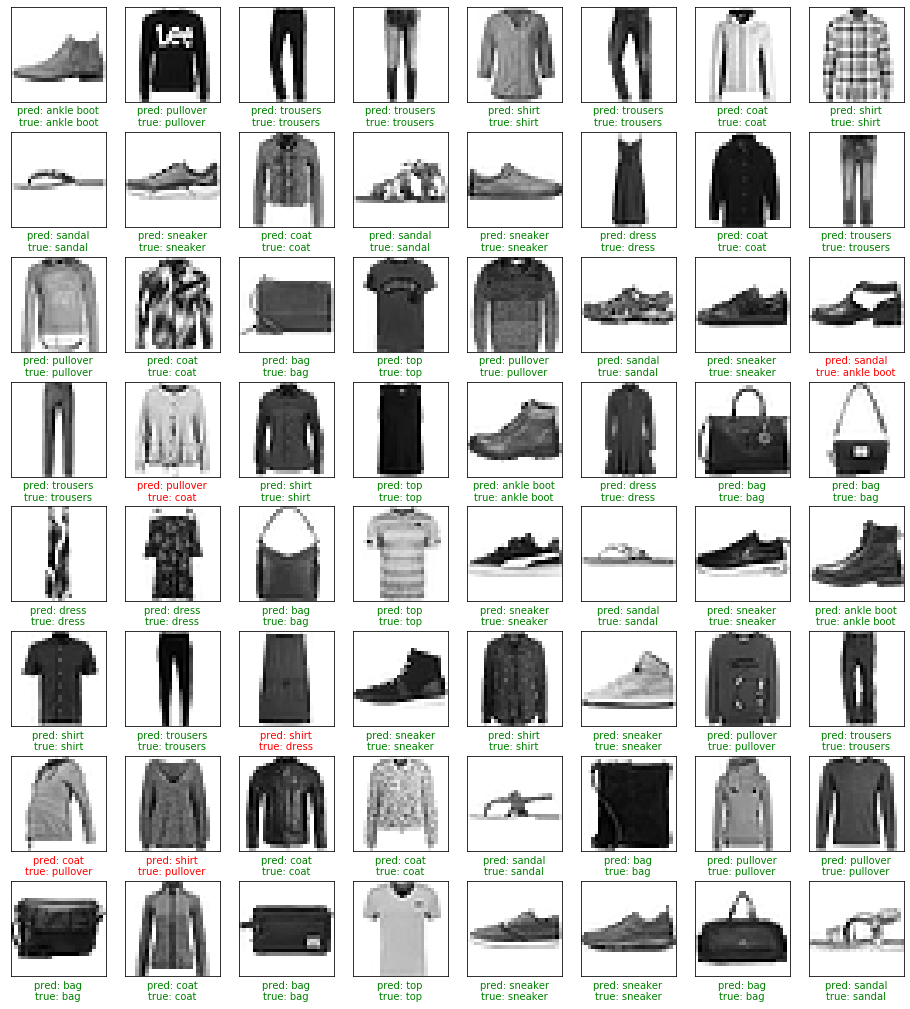

In [27]:
plot_predictions(models['convolutional net'])

In [28]:
data = OrderedDict()
for name, model in models.items():
    data[name] = OrderedDict([
        ('training set', f'{accuracy_score(train_y, model.predict(train_x)):.3f}'),
        ('validation set', f'{accuracy_score(val_y, model.predict(val_x)):.3f}'),
        ('test set', f'{accuracy_score(test_y, model.predict(test_x)):.3f}')])
display(DataFrame(data))

,nearest centroid,random forest,multilayer perceptron,convolutional net
training set,0.686,0.998,0.920,0.938
validation set,0.675,0.874,0.886,0.911
test set,0.678,0.872,0.891,0.915


In [29]:
data = OrderedDict()
for name, model in models.items():
    precision, recall, fscore, _ = precision_recall_fscore_support(
        test_y, model.predict(test_x))
    data[(name, 'precision')] = OrderedDict([
        (labels[i], f'{s:.3f}') for i, s in enumerate(precision)])
    data[(name, 'recall')] = OrderedDict([
        (labels[i], f'{s:.3f}') for i, s in enumerate(recall)])
    data[(name, 'f-score')] = OrderedDict(
        [(labels[i], f'{s:.3f}') for i, s in enumerate(fscore)])
display(DataFrame(data))

nearest centroid                random forest                 \
                  precision recall f-score     precision recall f-score   
top                   0.712  0.696   0.704         0.801  0.842   0.821   
trousers              0.976  0.867   0.918         0.996  0.944   0.969   
pullover              0.538  0.457   0.494         0.766  0.800   0.782   
dress                 0.688  0.750   0.718         0.868  0.910   0.889   
coat                  0.505  0.564   0.533         0.755  0.829   0.790   
sandal                0.511  0.767   0.613         0.972  0.961   0.967   
shirt                 0.331  0.212   0.259         0.712  0.568   0.632   
sneaker               0.765  0.834   0.798         0.929  0.946   0.938   
bag                   0.904  0.751   0.820         0.943  0.979   0.961   
ankle boot            0.867  0.872   0.869         0.956  0.945   0.950   

           multilayer perceptron                convolutional net         \
                       precision recall f-score         precision recall   
top                        0.835  0.854   0.845             0.882  0.846   
trousers                   0.992  0.967   0.980             0.996  0.971   
pullover                   0.796  0.837   0.816             0.893  0.889   
dress                      0.902  0.916   0.909             0.897  0.940   
coat                       0.779  0.839   0.808             0.847  0.889   
sandal                     0.994  0.944   0.968             0.986  0.961   
shirt                      0.742  0.639   0.687             0.760  0.739   
sneaker                    0.918  0.982   0.949             0.940  0.980   
bag                        0.975  0.983   0.979             0.979  0.979   
ankle boot                 0.965  0.948   0.957             0.973  0.960   

                    
           f-score  
top          0.863  
trousers     0.983  
pullover     0.891  
dress        0.918  
coat         0.868  
sandal       0.973  
shirt        0.750  
sneaker      0.960  
bag          0.979  
ankle boot   0.966

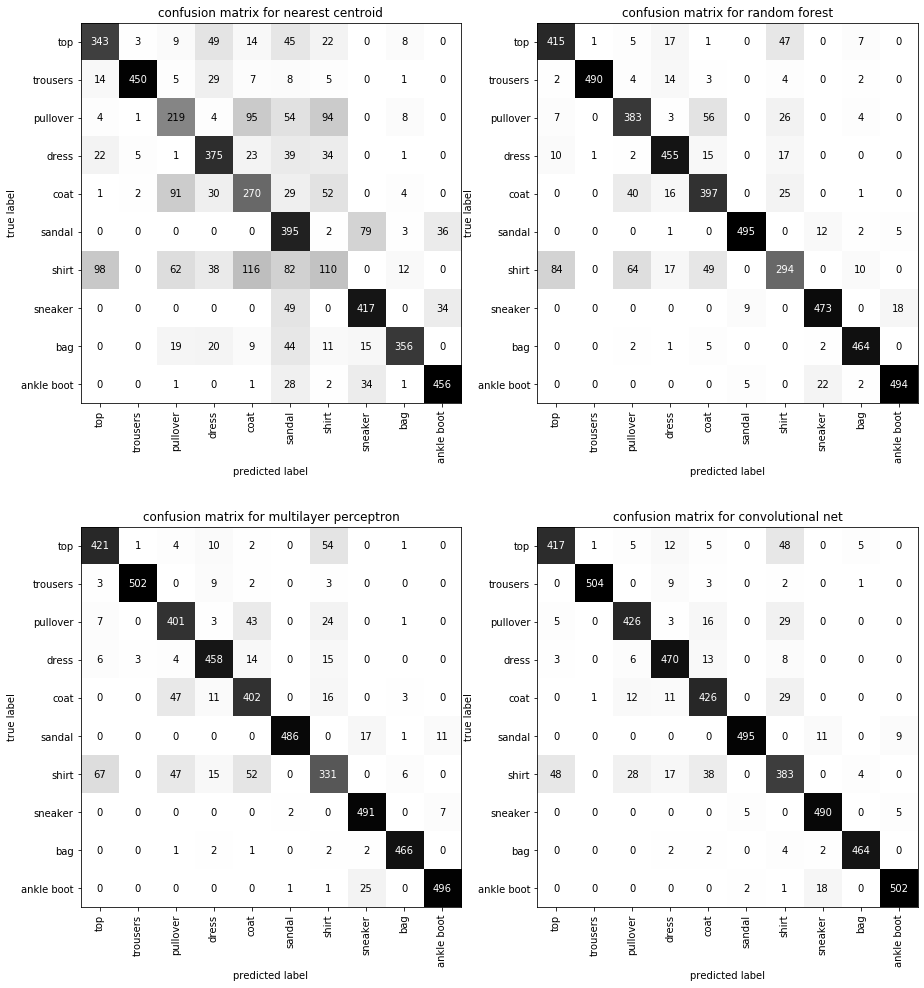

In [30]:
plt.figure(figsize=(15, 17))
for i, (name, model) in enumerate(models.items()):
    cm = confusion_matrix(test_y, model.predict(test_x))
    threshold = np.max(cm) / 2
    plt.subplot(2, 2, i + 1)
    plt.imshow(cm, cmap=plt.cm.binary)
    for i, _ in enumerate(labels):
        for j, _ in enumerate(labels):
            plt.text(
                j, i, cm[i, j], color='white' if cm[i, j] > threshold else 'black',
                horizontalalignment='center', verticalalignment='center')
    plt.title(f'confusion matrix for {name}')
    plt.xlabel('predicted label')
    plt.xticks(range(len(labels)), labels, rotation=90)
    plt.ylabel('true label')
    plt.yticks(range(len(labels)), labels)
plt.show()